### Projection Analysis: 

In [16]:
import sys, argparse, os, glob
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from pytorch_lightning.loggers import WandbLogger
sys.path.insert(0, '../')
from pytorch_lightning import Trainer
from dataProcessing.dataModule import SingleDatasetModule
from models.pseudoLabSelection import getPseudoLabel
from trainers.trainerClf import ClfModel
from trainers.trainerTL import TLmodel
from Utils.myUtils import  MCI,getTeacherParams

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [37]:
inPath = 'C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\frankDataset\\'
params_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\experiments\\params\\oficial\\'
save_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\saved\\teacherOficial_v2\\'



datasetList = ['Dsads','Ucihar','Uschad','Pamap2']
n_classes = 4 
source = 'Pamap2'
target = 'Dsads'
paramsPath = os.path.join(params_path, source[:3] + target[:3] + ".json")

###  Dsads to Ucihar: 

In [38]:
teacherParams = getTeacherParams(paramsPath)
dm_target = SingleDatasetModule(data_dir=inPath,
                                datasetName=target,
                                input_shape=(2,50,3),
                                n_classes=4,
                                batch_size=128,
                                shuffle=True)

dm_target.setup(normalize=True)
model = TLmodel(trainParams=teacherParams,
                n_classes=4,
                lossParams=None,
                save_path=None,
                class_weight=None)

model.setDatasets(dm_target = dm_target)
model.create_model()
model.load_params(save_path,f'Disc_class{source}_{target}')
predT = model.getPredict(domain='Target')


In [39]:
pred = {}
pred['latent'] = predT['latentTarget']
pred['pred']   = predT['predTarget']
pred['true']   = predT['trueTarget']
pred['probs']  = predT['probTarget']
pred['data']   = predT['dataTarget']


accIni = accuracy_score(pred['true'], pred['pred'])
f1Ini = f1_score(pred['true'], pred['pred'],average = 'weighted')
cm = confusion_matrix(pred['true'], pred['pred'])

<AxesSubplot:title={'center':'Predictions of Dsads trained in Pamap2 - Acc = 63.11'}>

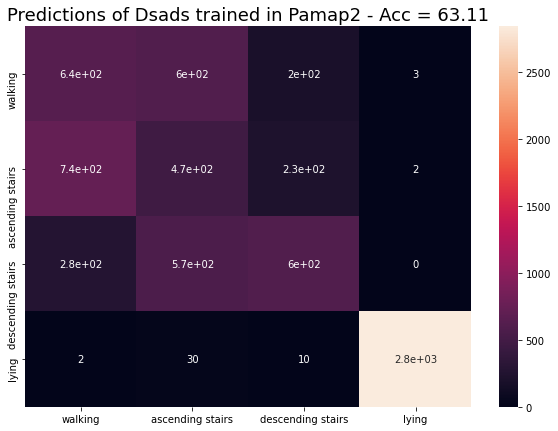

In [40]:
classes = ['walking','ascending stairs','descending stairs','lying']
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
acc = "%.2f" % round(accIni*100, 2)
plt.title(f'Predictions of {target} trained in {source} - Acc = {acc}',fontsize = 18)
sn.heatmap(df_cm, annot=True)

'73.43'

In [41]:
# source_embedded = TSNE(n_components=2).fit_transform(latentSource)
target_embedded = TSNE(n_components=2).fit_transform(pred['latent'])


Text(0.5, 1.0, 'Prediction Labels')

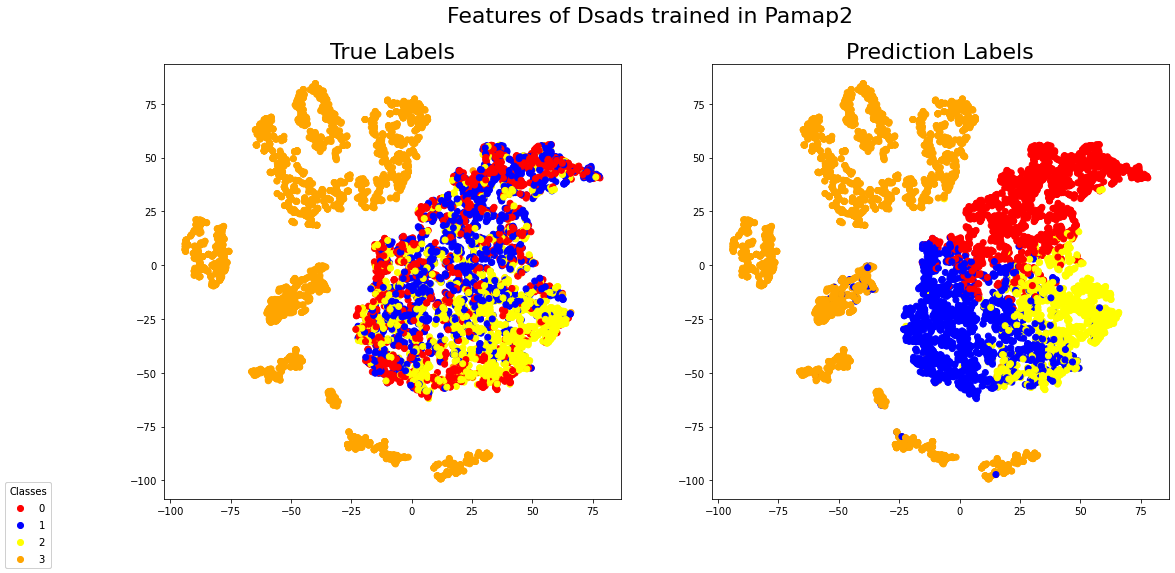

In [42]:
x = target_embedded[:,0]
y = target_embedded[:,1]
label = pred['true']
colors = ['red','green','blue','purple','yellow','orange']
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,8))
fig.suptitle(f'Features of {target} trained in {source}',fontsize = 22)
scatter = ax[0].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title(f'True Labels',fontsize = 22)
label = pred['pred']
colors = ['red','green','blue','purple','yellow','orange']
scatter = ax[1].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
# legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
# ax[1].add_artist(legend1)
ax[1].set_title(f'Prediction Labels',fontsize = 22)
# plt.savefig(os.path.join(save_path,f'features_from{source}_to{target}.png'))



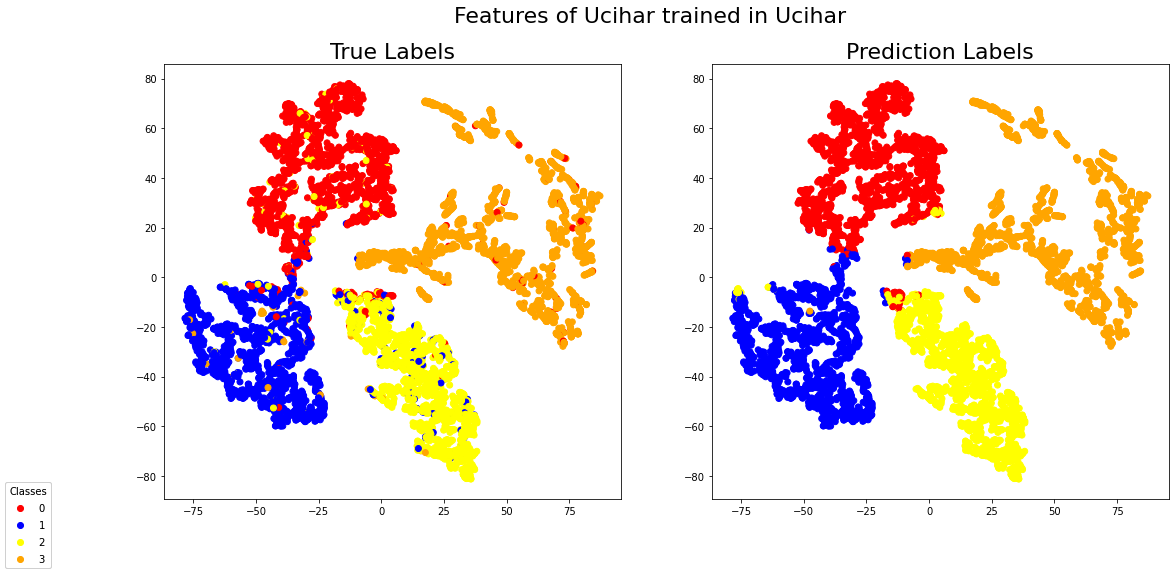

In [34]:
# x = source_embedded[:,0]
# y = source_embedded[:,1]
# label = trueSource
# colors = ['red','green','blue','purple','yellow','orange']
# fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,8))
# fig.suptitle(f'Features of {source} trained in {source}',fontsize = 22)
# scatter = ax[0].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
# legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
# ax[0].add_artist(legend1)
# ax[0].set_title(f'True Labels',fontsize = 22)

# label = predSource
# colors = ['red','green','blue','purple','yellow','orange']
# scatter = ax[1].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
# #legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
# #ax[1].add_artist(legend1)
# ax[1].set_title(f'Prediction Labels',fontsize = 22)
# plt.savefig(os.path.join(save_path,f'featuresSource_{source}.png'))


### Analysing Classsifier confidence:

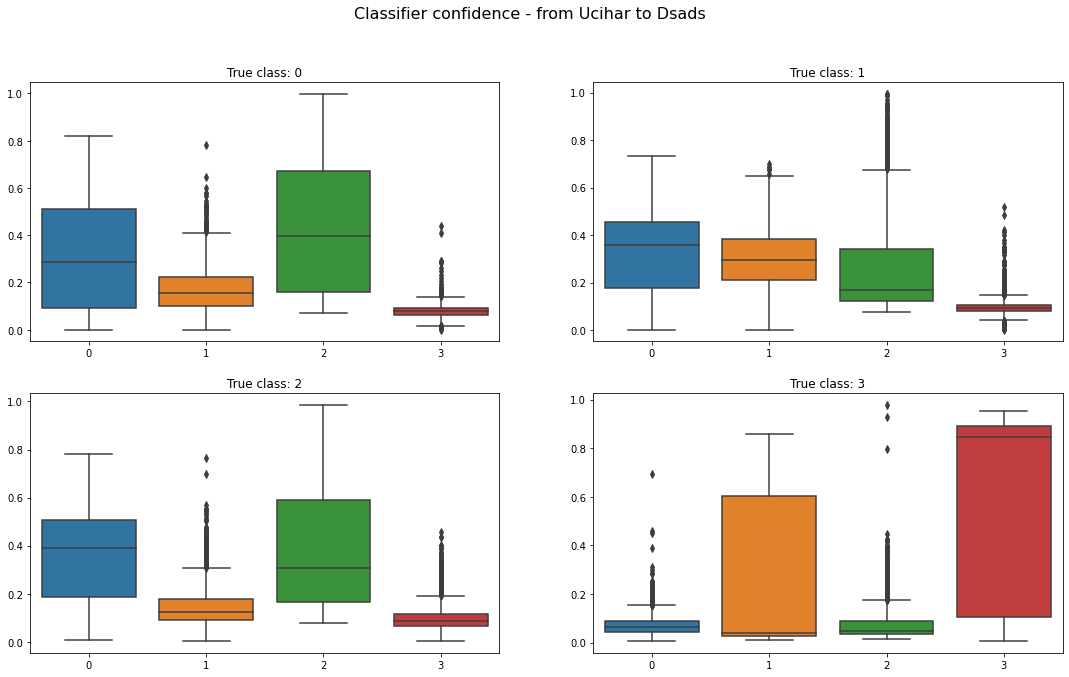

In [39]:
lim = 7.5
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle(f'Classifier confidence - from {source} to {target}', fontsize=16)
for i in range(4):
    probs = probsTarget[np.where(trueTarget==i)[0]]
    sns.boxplot(data = pd.DataFrame(probs),ax = axs[int(i/2),i%2])
    axs[int(i/2),i%2].set_title(f'True class: {i}')
plt.savefig(f'../figures/clf_confidence_{source}to{target}.png')

A partir dos resultados analizado, apenas a classe 3 apresenta um desempenho satisfatório. 
Mas vale a pena o teste. A classe 3 é de fato mais discriminativa de todas. Quando ela é verdadadeira, a probabilidade média a mais alta.
Quando não é, os valores são os menores. 
Não dá pra prever o comportamento durante o treino, pois com a adição de labels a distribuição dessas probabilidades irá mudar. 

In [16]:

predSL =[]
trueSL = []
for t,p in zip(trueTarget,probsTarget):
    if max(p) > 0.8:
        predSL.append(np.argmax(p))
        trueSL.append(t)

In [17]:
accuracy_score(trueSL,predSL)

0.8392029657089898

In [18]:
len(trueSL)/len(trueTarget)

0.30106026785714285

In [19]:
accuracy_score(trueTarget,predTarget)

0.48130580357142855